# The Relationship Between Doubles and HRs

### MSP 8.28.2017

Are HRs failed doubles?

In [ ]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import matplotlib as mpl



In [2]:
# imports for scraping

from bs4 import BeautifulSoup
import requests


# basic birth year reader. tables[1] has good stuff in it!
def get_birth_year(tables):

    birthdate_start = (tables[1].text).find("Birthdate:")

    birthdate_end =  (tables[1].text).find('(',birthdate_start)

    #print (tables[1].text)[birthdate_start:birthdate_end]
    birth_year = (tables[1].text)[birthdate_start:birthdate_end].split('/')[2]
    #print birth_year
    
    return birth_year





In [3]:
# the listing of the teams of interest (all!)

teams = ['angels','astros','athletics','bluejays','braves',\
        'brewers','cardinals','cubs','diamondbacks','dodgers',\
        'giants','indians','mariners','marlins','mets','nationals',\
        'orioles','padres','phillies','pirates','rangers',\
        'rays','reds','redsox','rockies','royals','tigers','twins',\
        'whitesox','yankees']

# verify we got all the teams...
print len(teams)

30


#### Compile Hitters

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [8]:
#
# make hitter dictionary
#
HDict = {}


for team in teams:
    
    print team,
    
    get_url = 'http://www.fangraphs.com/teams/'+team#angels'

    r  = requests.get(get_url)

    data = r.text

    soup = BeautifulSoup(data)

    tables = soup.findAll('table')


    for row in tables[5].find_all("tr")[1:]: 
    
        sav = [td.find('a') for td in row.find_all("td")][0]
    
        try:
            need_url = sav.get('href')
            
            sav2 = [td.get_text() for td in row.find_all("td")]
        
            # Apply a PA cut?
            if float(sav2[3]) > 200.:
                HDict[sav.text] = need_url[(need_url).find('playerid')+9:(need_url).find('&')]
        
        except:
            pass
    
f = open('data/batterdict.dat','w')

for entry in HDict.keys():
    try:
        print >>f,entry,'|',HDict[entry]
    except:
        print entry,'|',HDict[entry]
    

f.close()

angels astros athletics bluejays braves brewers cardinals cubs diamondbacks dodgers giants indians mariners marlins mets nationals orioles padres phillies pirates rangers rays reds redsox rockies royals tigers twins whitesox yankees KikÃ© Hernandez | 10472


In [9]:

HDict = {}

f = open('data/batterdict.dat')

for line in f:
    #print line
    try:
        HDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    
    
print('Found {} hitters by scraping teams.'.format(len(HDict.keys())))

Found 311 hitters by scraping teams.


### First Application: Grabbing A Hitters AVG/OBP with age

How does a plot of avg/obp evolve with age?

In [23]:
#
# for an individual player
#'

itable = [u'Season', u'Team', u'G', u'AB', u'PA', u'H', u'1B', \
          u'2B', u'3B', u'HR', u'R', u'RBI', u'BB', u'IBB',\
          u'SO', u'HBP', u'SF', u'SH', u'GDP', u'SB', u'CS', u'AVG']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17      18       19      20     21


# these are categories to eliminate
projections = ['Depth Charts','Fans',\
               'Fans (6)','Fans (7)','Fans (11)','Fans (12)','Fans (14)','Fans (15)',\
               'Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average','Postseason']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total','Postseason']



plist = ['Joey Votto','Albert Pujols','Mike Trout']


#for player in HDict.keys():

def obtain_players(plist):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        PVals[player] = {}
        #print player,

        get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(HDict[player].strip())

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')

        PVals[player]['1B'] = []
        PVals[player]['2B'] = []
        PVals[player]['3B'] = []
        PVals[player]['HR'] = []


        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                print pnum,player

                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:

                    if (row in table.find_all("tr", class_="grid_postseason")) |\
                        (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue


                    sav = [td.get_text() for td in row.find_all("td")]

                    if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    (np.sum([(x in sav[1]) for x in minors])==0) & \
                    (np.sum([(x in sav[0]) for x in agg])==0) &\
                    (sav[0] == '2017'): 
                        try:
                            #print sav[0]
                            float(sav[-1])
                            float(sav[0])

                            #print sav[0],sav[1],float(sav[4])>50.

                            # current problem is that postseason is mixed in

                            if (float(sav[4])>50.):
                                # sav[4] is PA
                                PVals[player]['1B'].append(float(sav[6]))
                                PVals[player]['2B'].append(float(sav[7]))
                                PVals[player]['3B'].append(float(sav[8]))
                                PVals[player]['HR'].append(float(sav[9]))

                            #if (float(sav[7])<50.):
                            #    print 'rejected for too few innings:',sav[0],float(sav[7])

                        except:
                            # this is janky way to skip postseason. please fix this
                            #print 'Skipped for postseason',sav[0],sav[1]
                            pass

    return PVals


PValsFull = obtain_players(HDict.keys())



0 Rougned Odor
1 Justin Upton
2 Brad Miller
3 Kevan Smith
4 Ryan Braun
5 Jose Bautista
6 Carlos Asuaje
7 Hunter Pence
8 Stephen Piscotty
9 Cameron Maybin
10 Hernan Perez
11 Adam Duvall
12 Adrian Gonzalez
13 Matt Joyce
14 Daniel Robertson
15 Dustin Pedroia
16 Gary Sanchez
17 J.T. Realmuto
18 Nori Aoki
19 Joey Gallo
20 Evan Gattis
21 Gregor Blanco
22 Ian Kinsler
23 Chris Owings
24 Christian Vazquez
25 Kevin Pillar
26 J.T. Riddle
27 Mike Zunino
28 Greg Garcia
29 Caleb Joseph
30 Denard Span
31 Adam Engel
32 Jose Ramirez
33 Melky Cabrera
34 Corey Dickerson
35 Tommy Pham
36 Kolten Wong
37 Mitch Haniger
38 Albert Pujols
39 Billy Hamilton
40 Orlando Arcia
41 Travis d'Arnaud
42 Robbie Grossman
43 Neil Walker
44 Joe Panik
45 Freddy Galvis
46 Gorkys Hernandez
47 Jason Castro
48 Welington Castillo
49 Francisco Lindor
50 Ben Zobrist
51 Jackie Bradley Jr.
52 George Springer
53 Starling Marte
54 Jake Lamb
55 Brandon Moss
56 Eduardo Escobar
57 Kyle Schwarber
58 Tyler Flowers
59 Shin-Soo Choo
60 Randal

In [35]:


def plot_plist(plist,PVals):

    fig = plt.figure(figsize=(5,3))

    ax1 = fig.add_axes([0.15,0.53,0.35,0.35])
    ax2 = fig.add_axes([0.53,0.53,0.35,0.35])
    ax3 = fig.add_axes([0.15,0.15,0.35,0.35])
    ax4 = fig.add_axes([0.53,0.15,0.35,0.35])
    ax5 = fig.add_axes([0.9,0.15,0.02,0.75])

    clrs = cm.gnuplot

    oneb = np.array([PValsFull[x]['1B'] for x in PValsFull.keys()])
    twob = np.array([PValsFull[x]['2B'] for x in PValsFull.keys()])
    threeb = np.array([PValsFull[x]['3B'] for x in PValsFull.keys()])
    fourb = np.array([PValsFull[x]['HR'] for x in PValsFull.keys()])
    
    ax1.hexbin(threeb,oneb,cmap=cm.Greys,gridsize=10)
    ax2.hexbin(fourb,oneb,cmap=cm.Greys,gridsize=10)
    ax3.hexbin(threeb,twob,cmap=cm.Greys,gridsize=10)
    ax4.hexbin(fourb,twob,cmap=cm.Greys,gridsize=10)


    for indx,player in enumerate(plist):
        ax1.scatter(PVals[player]['3B'],PVals[player]['1B'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax2.scatter(PVals[player]['HR'],PVals[player]['1B'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax3.scatter(PVals[player]['3B'],PVals[player]['2B'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax4.scatter(PVals[player]['HR'],PVals[player]['2B'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))



    ax3.set_xlabel('3B',size=18)
    ax1.set_ylabel('1B',size=18)
    ax3.set_ylabel('2B',size=18)
    ax4.set_xlabel('HRs',size=18)

    ax2.set_xticklabels(())
    ax2.set_yticklabels(())
    ax1.set_xticklabels(())
    ax4.set_yticklabels(())




    norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(plist)+1.), ncolors=256)
    cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cm.gnuplot,norm=norm)
    cb1.set_label('Players',size=16)
    cb1.set_ticks(np.linspace(0.,1.,len(plist)+1.) + 0.5/(len(plist)+1.))
    cb1.set_ticklabels(plist)



### Top 10 Players

0 Charlie Blackmon
1 Paul Goldschmidt
2 Jose Altuve
3 Giancarlo Stanton
4 Aaron Judge
5 Joey Votto
6 Bryce Harper
7 Nolan Arenado


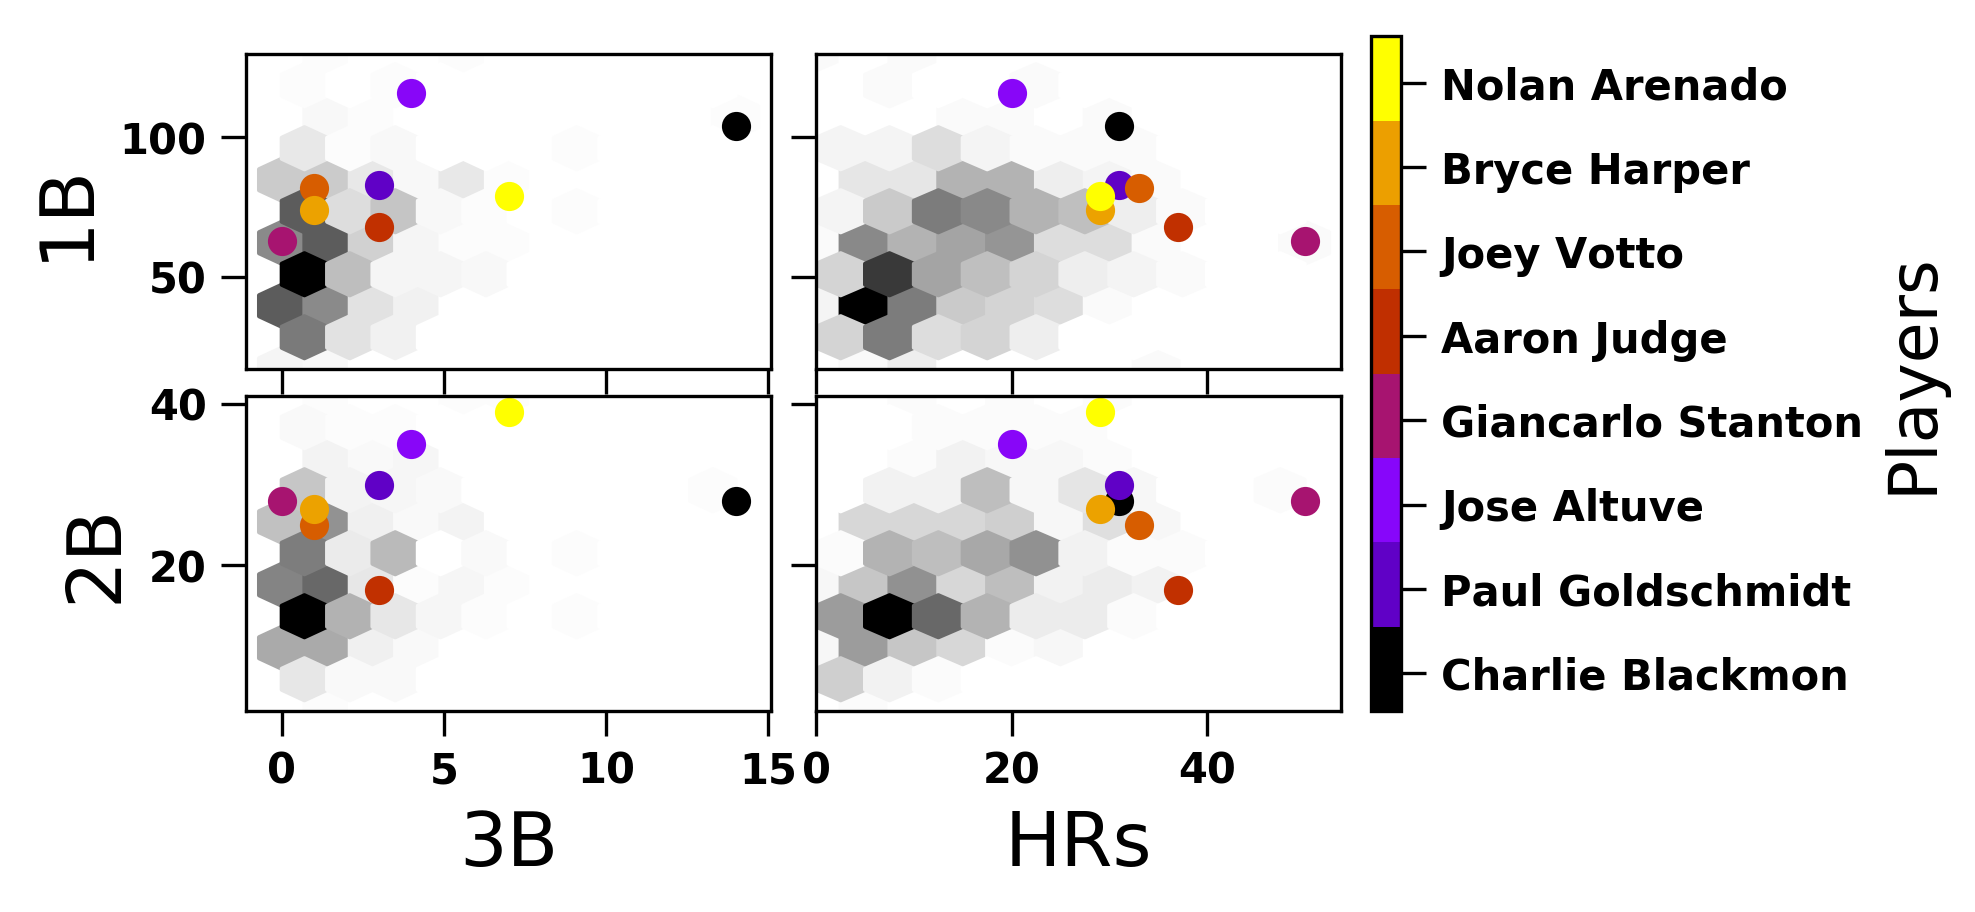

In [39]:

plist = ['Charlie Blackmon','Paul Goldschmidt','Jose Altuve','Giancarlo Stanton',\
         'Aaron Judge','Joey Votto','Bryce Harper','Nolan Arenado']

PVals = obtain_players(plist)

plot_plist(plist,PVals)

### What about some of the older gentlemen?

0 Joey Votto
1 Justin Upton
2 Nelson Cruz
3 Ryan Zimmerman
4 Justin Smoak
5 Andrew McCutchen
6 Daniel Murphy


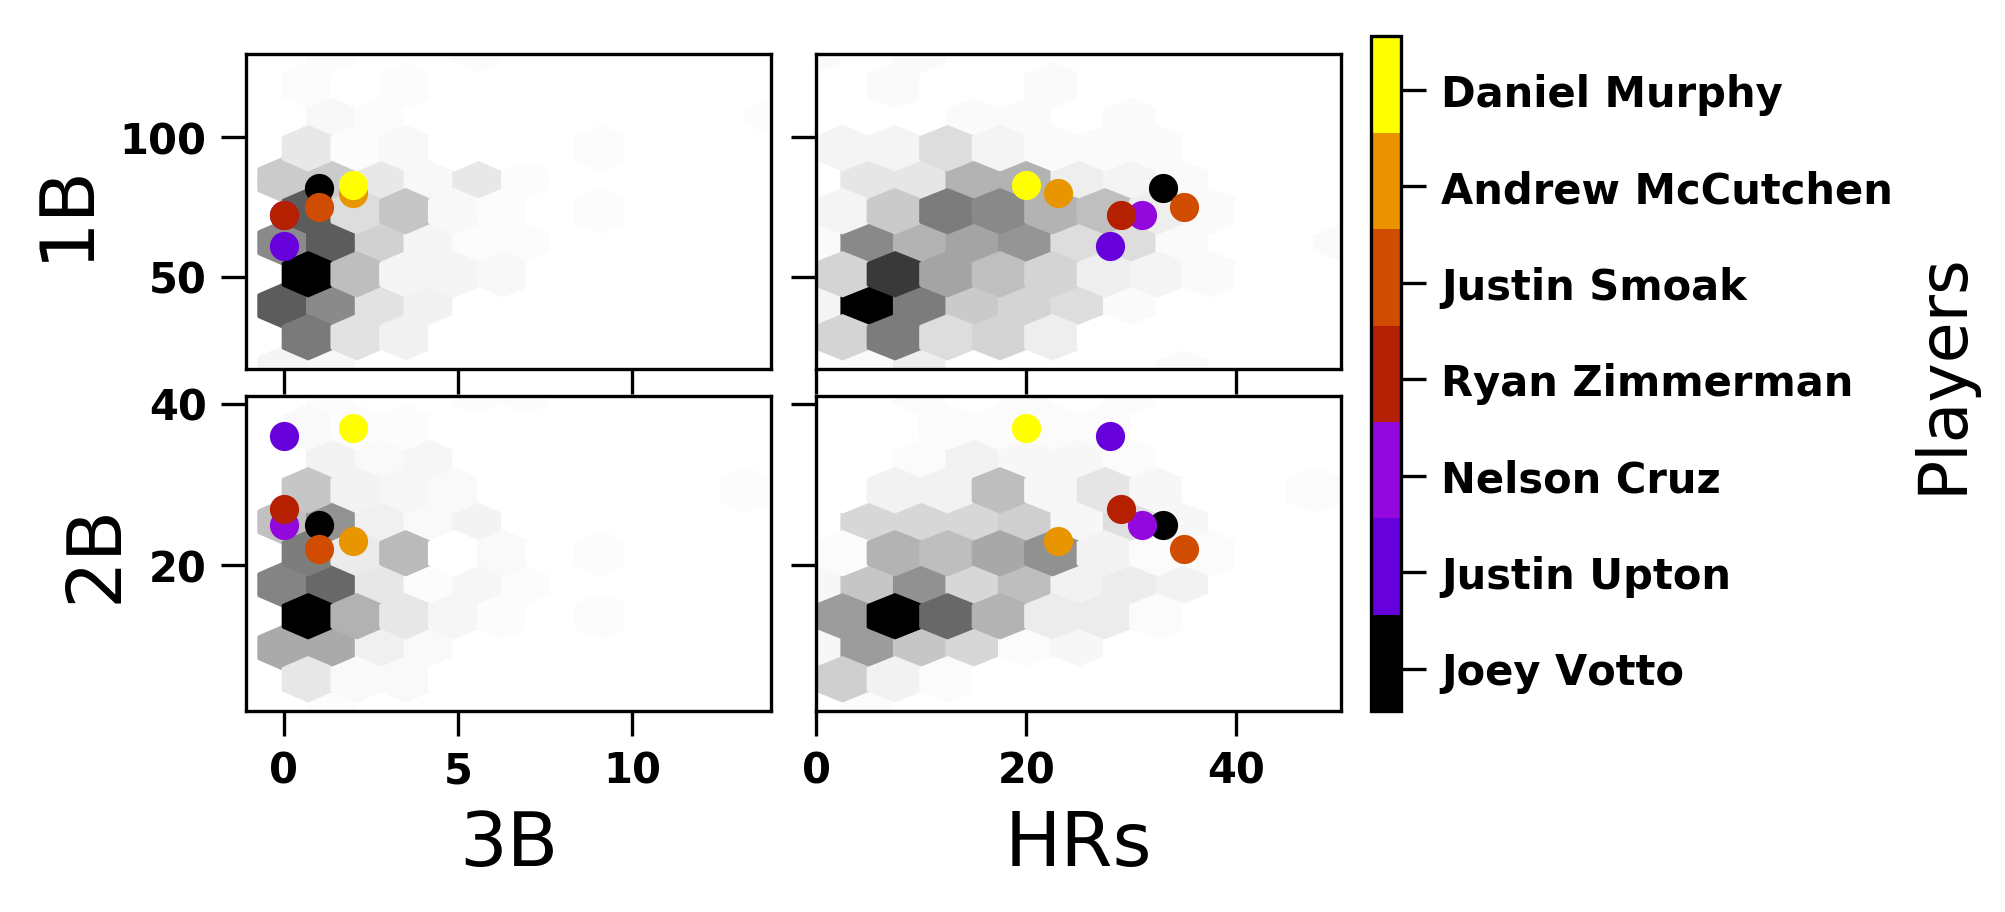

In [38]:
plist = ['Joey Votto','Justin Upton','Nelson Cruz','Ryan Zimmerman','Justin Smoak','Andrew McCutchen','Daniel Murphy']

PVals = obtain_players(plist)

plot_plist(plist,PVals)

In [61]:
from sklearn.decomposition import PCA


oneb = np.array([PValsFull[x]['1B'] for x in PValsFull.keys()])
twob = np.array([PValsFull[x]['2B'] for x in PValsFull.keys()])
threeb = np.array([PValsFull[x]['3B'] for x in PValsFull.keys()])
fourb = np.array([PValsFull[x]['HR'] for x in PValsFull.keys()])

#print oneb.T[0]
X = np.array([oneb.T[0],twob.T[0],fourb.T[0]]).T

#print X
pca = PCA(n_components=2)


pca.fit(X)

Y = pca.transform(X)

In [96]:

oneb = np.array([PVals[x]['1B'] for x in PVals.keys()])
twob = np.array([PVals[x]['2B'] for x in PVals.keys()])
threeb = np.array([PVals[x]['3B'] for x in PVals.keys()])
fourb = np.array([PVals[x]['HR'] for x in PVals.keys()])

#print oneb.T[0]
X = np.array([oneb.T[0],twob.T[0],fourb.T[0]]).T

Z = pca.transform(X)


# make some basic metric lines
oneb = np.arange(0.,100.,1.)
twob = np.arange(0.,100.,1.)
threeb = np.arange(0.,100.,1.)
fourb = np.arange(0.,100.,1.)

#print oneb.T[0]
X = np.array([oneb.T,twob.T,fourb.T]).T

W = pca.transform(X)

oneb = np.linspace(0.,100.,100)
twob = np.linspace(0.,30.,100)
fourb = np.linspace(0.,30.,100)

#print oneb.T[0]
X = np.array([oneb.T,twob.T,fourb.T]).T

WW = pca.transform(X)

oneb = np.linspace(0.,100.,100)
twob = np.linspace(0.,60.,100)
fourb = np.linspace(0.,30.,100)

#print oneb.T[0]
X = np.array([oneb.T,twob.T,fourb.T]).T

WWW = pca.transform(X)

# crazy one
oneb = np.linspace(0.,0.,100)
twob = np.linspace(0.,60.,100)
fourb = np.linspace(0.,30.,100)

#print oneb.T[0]
X = np.array([oneb.T,twob.T,fourb.T]).T

W4 = pca.transform(X)

# crazy one
oneb = np.linspace(0.,100.,100)
twob = np.linspace(0.,0.,100)
fourb = np.linspace(0.,30.,100)

#print oneb.T[0]
X = np.array([oneb.T,twob.T,fourb.T]).T

W5 = pca.transform(X)

# No HR
oneb = np.linspace(0.,100.,100)
twob = np.linspace(0.,50.,100)
fourb = np.linspace(0.,00.,100)

#print oneb.T[0]
X = np.array([oneb.T,twob.T,fourb.T]).T

W6 = pca.transform(X)

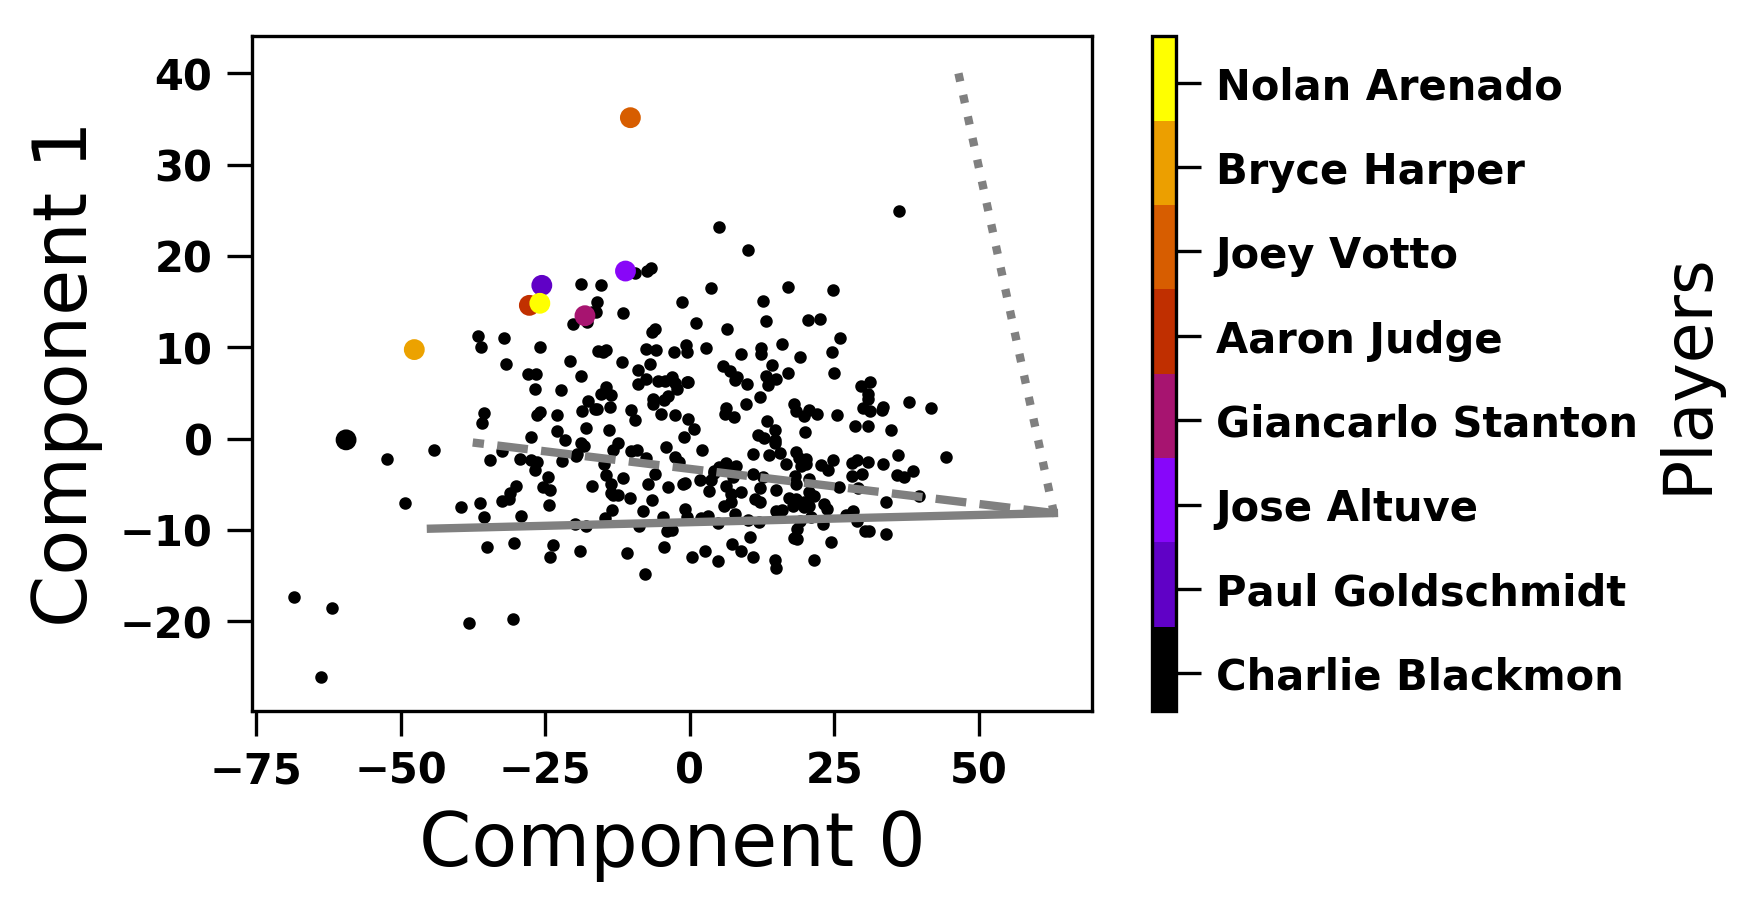

In [98]:

fig = plt.figure(figsize=(4,3))

ax1 = fig.add_axes([0.15,0.15,0.7,0.75])
ax2 = fig.add_axes([0.9,0.15,0.02,0.75])

#ax1.plot(WW[:,0],WW[:,1],color='gray')
#ax1.plot(WWW[:,0],WWW[:,1],color='gray')
ax1.plot(W4[:,0],W4[:,1],color='gray',linestyle='dotted') # no 1b
ax1.plot(W5[:,0],W5[:,1],color='gray',linestyle='dashed') # no 2b
ax1.plot(W6[:,0],W6[:,1],color='gray',linestyle='solid') # no hr





clrs_indx = np.arange(0.,len(plist),1.)/float(len(plist)-1.)


ax1.scatter(Y[:,0],Y[:,1],color='black',s=4.)
ax1.scatter(Z[:,0],Z[:,1],color=cm.gnuplot(clrs_indx,1.),s=16.)
#plt.plot(W[:,0],W[:,1],color='gray')

ax1.set_xlabel('Component 0',size=18)
ax1.set_ylabel('Component 1',size=18)

norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(plist)+1.), ncolors=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cm.gnuplot,norm=norm)
cb1.set_label('Players',size=16)
cb1.set_ticks(np.linspace(0.,1.,len(plist)+1.) + 0.5/(len(plist)+1.))
cb1.set_ticklabels(plist)


In [108]:
w = np.where( (Y[:,1] > 12) & (Y[:,0] < 0))[0]
#print w
#print [HDict.keys()[x] for x in w]

for x in w:
    print HDict.keys()[x],PValsFull[HDict.keys()[x]]['HR'][0]


Justin Upton 28.0
Gary Sanchez 27.0
Kolten Wong 4.0
Eduardo Escobar 12.0
Marcus Semien 5.0
Brandon Drury 10.0
Daniel Descalso 8.0
Alex Bregman 16.0
Jose Abreu 26.0
Keon Broxton 20.0
Nolan Arenado 29.0
Jedd Gyorko 18.0
Mike Napoli 27.0
Danny Espinosa 6.0
Albert Almora Jr. 5.0
Domingo Santana 21.0
Josh Donaldson 23.0
Scott Schebler 25.0
Manny Pina 9.0
